In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
import seaborn as sns

In [2]:
df = pd.read_csv("SMSSpamCollection.txt", sep='\t', names=['labels', 'texts'])
print(df.shape)
df.head()

(5572, 2)


,labels,texts
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


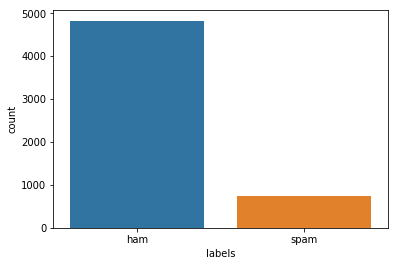

In [3]:
sns.countplot(df.labels);

In [4]:
y = df.labels.map({'ham': 0, 'spam': 1}).values
X = df.texts

In [5]:
def text_classifier(vectorizer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("classifier", classifier)]
        )

# Оценка качества бейзлайна; тест классификатора на отдельных примерах

*Оценим качество классификации текстов с помощью LogisticRegression() с параметрами по умолчанию, используя кросс-валидацию и посчитав среднее качество на 10 fold'ах. В качестве метрики качества возьмем f1-меру.*

In [6]:
logreg = LogisticRegression(random_state=2)
baseline = cross_val_score(text_classifier(CountVectorizer(), logreg), X, y, cv=10, scoring='f1').mean()
print("baseline (Logistic regression) average f1 score = %.2f" % baseline)

baseline (Logistic regression) average f1 score = 0.93


 *Обучим классификатор на всей выборке и проверим не некоторых сообщениях.*

In [7]:
clf_pipeline = text_classifier(CountVectorizer(), LogisticRegression()).fit(X, y)

clf_pipeline.predict(
    ["FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GB",
     "FreeMsg: Txt: claim your reward of 3 hours talk time",
     "Have you visited the last lecture on physics?",
     "Have you visited the last lecture on physics? Just buy this book and you will have all materials! Only 99$",
     "Only 99$"])

array([1, 1, 0, 0, 0], dtype=int64)

*Первые два сообщения модель оценила как спам.*

# Эксперименты с n-граммами, логистической регрессией и наивным Байесом

*Попробуем добавить в признаки n-граммы для разных диапазонов n - только биграммы, только триграммы, и, наконец, все вместе - униграммы, биграммы и триграммы*

In [8]:
dct_ngr = {'bigrams': (2, 2), 'trigrams': (3, 3), 'all together': (1, 3)}

def different_ngrams(clf):
    print(clf)
    for key, value in dct_ngr.items():
        vectorizer = CountVectorizer(ngram_range=value)
        corpus = vectorizer.fit_transform(X)
        res = cross_val_score(clf, corpus, y, cv=10, scoring='f1').mean()
        print("for %s average f1 score = %.2f" % (key, res))
    print("\n")

In [9]:
for clf in [LogisticRegression(random_state=2), MultinomialNB()]:
    different_ngrams(clf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
for bigrams average f1 score = 0.82
for trigrams average f1 score = 0.73
for all together average f1 score = 0.93


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
for bigrams average f1 score = 0.65
for trigrams average f1 score = 0.38
for all together average f1 score = 0.89




*Статистики по биграммам и триграммам намного меньше, поэтому классификатор только на них работает хуже. В то же время это не ухудшает результат сколько-нибудь существенно, если добавлять их вместе с униграммами, т.к. за счет регуляризации линейный классификатор не склонен сильно переобучаться на этих признаках.*

*Кроме того, видно, что наивный Байес сильнее страдает от нехватки статистики по биграммам и триграммам.*

# Эксперимент с tf-idf на униграммах и логистической регрессии

*Попробуем использовать в логистической регрессии в качестве признаков tfidf из TfidfVectorizer на униграммах и сравним с результатом, полученным с использованием CountVectorizer на бейзлайне.*

In [10]:
res_tfidf = cross_val_score( text_classifier(TfidfVectorizer(), LogisticRegression(random_state=2)),
                                              X, y, cv=10, scoring='f1' ).mean() 

print('tf-idf: %.2f, CountVectorizer: %.2f' % (res_tfidf, baseline))
print(u'Качество бейзлайна выше на %.2f' % np.subtract(baseline, res_tfidf))

tf-idf: 0.88, CountVectorizer: 0.93
Качество бейзлайна выше на 0.05


*Результат перехода к tfidf не всегда будет таким - если вы наблюдаете какое-то явление на одном датасете, не надо сразу же его обобщать на любые данные.*